In [1]:
library(ggplot2)
library(ggseqlogo)
library(rtracklayer)
library(patchwork)

library(GenomicRanges)
library(readr)
library(magrittr)
library(dplyr)


Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


At

In [2]:
library(BSgenome.Hsapiens.UCSC.hg38)

genome = BSgenome.Hsapiens.UCSC.hg38

Loading required package: BSgenome

Loading required package: Biostrings

Loading required package: XVector


Attaching package: ‘Biostrings’


The following object is masked from ‘package:base’:

    strsplit




In [ ]:
#config = read.table("./GM12878_corrected_scaled.tsv", header=T, stringsAsFactors=F, sep='\t')
#config

#region_coorda

## Load Data

In [3]:
# one bigwig at a time, any number of peaks
get_matrix_from_bigwig <- function(bigwig_path, peak_set) {
    # ensure peak set has fixed width
    stopifnot(length(unique(width(peak_set)))==1)
    
    as.matrix(import(bigwig_path, 
      which=peak_set, as="NumericList"))
}

# one bigwig, one peak (GRanges object)
get_importance_from_bigwig <- function(bigwig_path, peak, genome) {
    stopifnot(length(peak)==1)
    
    # get DNA sequence
    sequence = genome[[as.vector(seqnames(peak))]][start(peak):end(peak)]
    
    m = matrix(0, length(sequence), 4)
    colnames(m) = c("A", "C", "G", "T")
    m[cbind(seq(length(sequence)), as.vector(matrix(sequence)))] = get_matrix_from_bigwig(bigwig_path, peak)

    t(m)
}

In [4]:
GRangesFromDataFrames<-function(dataframe){with(dataframe,GRanges(IRanges(start=start,end=end),seqnames=seqnames,strand=strand,dataframe%>%dplyr::select(-strand,-start,-end,-seqnames)))}

calculate_total_value_and_length <- function(bw_path,region){
    total_value = as.integer(sum(as.vector(get_matrix_from_bigwig(bw_path, region))))
    length = length(as.vector(get_matrix_from_bigwig(bw_path, region)))
    df = data.frame(total_value=total_value,length=length)
    df
}

calculate_normalization_value <- function(bw_path,peaks_path,mc.cores=40){
        peaks_df = read_tsv(peaks_path,
                         col_names=c("seqnames","start","end","name","score","strand","p","q","x","summit"),
                         show_col_types = FALSE)
        peaks_df['strand']<-'*'
        valid_chrs = c('chr1',"chr2","chr3","chr4","chr5","chr6","chr7","chr8","chr9","chr10",
                                 "chr11","chr12","chr13","chr14","chr15","chr16","chr17","chr18","chr19","chr20",
                                 "chr21","chrX","chrY")
        peaks_df[peaks_df[["seqnames"]] %in% valid_chrs,]
        peaks_gr = GRangesFromDataFrames(peaks_df)

        peaks_gr = keepSeqlevels(peaks_gr, c('chr1',"chr2","chr3","chr4","chr5","chr6","chr7","chr8","chr9","chr10",
                                 "chr11","chr12","chr13","chr14","chr15","chr16","chr17","chr18","chr19","chr20",
                                 "chr21","chrX"), pruning.mode="coarse")

        print(bw_path)
        1:length(peaks_gr) %>% mclapply(function(i){
                                        calculate_total_value_and_length(bw_path,peaks_gr[i])
                                        },mc.cores=mc.cores
                                        ) %>% bind_rows() -> normalization_df

        sum(normalization_df["total_value"])/sum(normalization_df["length"])
}



## Plot types

In [4]:
TITLE_SZ = 16

### Importance

In [188]:
plot_seq <- function(m, ymin=NULL, ymax=NULL, clip=F) {
    mat = m
    
#     rownames(mat) = c("A", "C", "G", "T")
    
    # cap to upper and lower limits
    if (clip==T) {
        if (!is.null(ymin)) {
            mat[mat<ymin] = ymin
        }
        
        if (!is.null(ymax)) {
            mat[mat>ymax] = ymax
        }
    }
    

    p = ggseqlogo(mat, method='custom', seq_type='dna') 
    
    p = (p + 
         theme_classic() + 
         coord_cartesian(ylim=c(ymin, ymax)) + 
         expand_limits(x=0, y=0) +
         #scale_y_continuous(breaks=c(ymin, ymax)) +
         theme(axis.ticks.x = element_blank(), axis.text.x = element_blank(),axis.title.x = element_blank(),axis.line.x = element_blank()))
    
    p = p + theme(axis.ticks.y = element_blank(),axis.text.y = element_blank())

    p
}

plot_importance <- function(bigwig_path, region, genome, ylabel, ymin=NULL, ymax=NULL, clip=F) {
    plot_seq(get_importance_from_bigwig(bigwig_path, region, genome), ymin=ymin, ymax=ymax, clip=clip) +
        ylab(gsub("\\\\n", "\n", ylabel)) +
        theme(axis.title.y = element_text(angle=0, size=TITLE_SZ, hjust=0.5, vjust=0.5))
}

### Single Track

In [283]:
plot_single_vals <- function(v, ymin=NULL, ymax=NULL, 
                             clip=F, fill=T, 
                             col='#37ada2',x_width) {
    vals = v
    
#     rownames(mat) = c("A", "C", "G", "T")
    
    # cap to upper and lower limits
    if (clip==T) {
        if (!is.null(ymin)) {
            vals[vals<ymin] = ymin
        }
        
        if (!is.null(ymax)) {
            vals[vals>ymax] = ymax
        }
    }
    
    p = ggplot(data.frame(x=seq(length(vals)), y=vals), aes(x=x,y=y)) 
    
    if (fill==T) {
        p = p + geom_area(fill=col)
    }
    
    else {
        p = p + geom_line(col=col)
    }
    
    p = (p + 
         theme_classic() + 
         coord_cartesian(ylim=c(0, ceiling(max(vals)))) + 
         expand_limits(x=0, y=0) +
         #scale_y_continuous(breaks=pretty(c(0, max(vals)),n=2,min.n=1)) +
         scale_y_continuous(breaks=c(0, ceiling(max(vals)))) +
         theme(axis.ticks.x = element_blank(), axis.text.x = element_blank(),axis.title.x = element_blank(),axis.line.x = element_blank()))
    
    p = p + theme(axis.text.y = element_text(size=14))
    
    p
}

plot_single <- function(bigwig_path, region, 
                        ylabel, ymin=NULL, ymax=NULL, 
                        fill=T, col='#37ada2', clip=F,
                        normalize = FALSE,normalization_value=None, normalization_region,normalization_file) {
    v1 = as.vector(get_matrix_from_bigwig(bigwig_path, region))
    if (normalize){
        #normalization_value = calculate_normalization_value(normalization_file,normalization_region)
        print(max(v1))
        print(normalization_value)
        v1=(v1/normalization_value)
        print(max(v1))
    }
    plot_single_vals(v1, ymin=ymin, ymax=ymax, clip=clip, fill=fill, col=col, x_width=width(region)) +
        ylab(gsub("\\\\n", "\n", ylabel)) +
        theme(axis.title.y = element_text(angle=0, size=TITLE_SZ, hjust=0.5,  vjust=0.5))
}

In [284]:
## scale


In [285]:
plot_scale_vals <- function(v, col='#a9d1ac') {
    vals = v
    
    p = ggplot(data.frame(x=seq(length(vals)), y=0), aes(x=x,y=y)) 
    
   
    p = p + geom_line(col=col)

    p = (p + 
         theme_classic() + 
         expand_limits(x=0, y=0) +
         scale_x_continuous(breaks=pretty(c(0, length(vals)/10),n=2,min.n=1)) +
         theme(axis.ticks.y = element_blank(), axis.text.y = element_blank(),axis.title = element_blank(),axis.line.y = element_blank())
        ) 
    
    p
}

plot_scale <- function(bigwig_path, region, ylabel, ymin=NULL, ymax=NULL, fill=T, col='#37ada2', clip=F) {
    plot_scale_vals(as.vector(get_matrix_from_bigwig(bigwig_path, region)), col=col) +
        ylab(ylabel) +
        theme(axis.title.y = element_text(angle=0, size=TITLE_SZ, hjust=0.5, vjust=0.5))
}

### Stranded Track

In [286]:
plot_stranded_vals <- function(v1, v2, ymin=NULL, 
                               ymax=NULL, clip=F, 
                               col1='blue', col2='orange') {
    vals1 = v1
    vals2 = v2
    
#     rownames(mat) = c("A", "C", "G", "T")
    
    # cap to upper and lower limits
    if (clip==T) {
        if (!is.null(ymin)) {
            vals1[vals1<ymin] = ymin
            vals2[vals2<ymin] = ymin
        }
        
        if (!is.null(ymax)) {
            vals1[vals1>ymax] = ymax
            vals2[vals2>ymax] = ymax
        }
    }
    
    p = ggplot(data.frame(x=seq(length(vals1)), y1=vals1, y2=vals2)) +
        geom_area(aes(x=x, y=y1), fill=col1, alpha = 0.8) +
        geom_area(aes(x=x, y=y2), fill=col2, alpha = 0.8) 

    p = (p + 
         theme_classic() + 
         coord_cartesian(ylim=c(ymin, ymax)) + 
         expand_limits(x=0, y=0) +
         scale_y_continuous(breaks=pretty(c(0, max(max(vals1),max(vals2))),n=2,min.n=1)) +
         theme(axis.ticks.x = element_blank(), axis.text.x = element_blank(),axis.title.x = element_blank(),axis.line.x = element_blank()))
    
    p

}

plot_stranded <- function(bigwig_prefix, region, ylabel, ymin=NULL, ymax=NULL,
                          clip=F, col1='blue', col2='orange',
                          normalize = FALSE,normalization_region,normalization_file_prefix) {
    # plus and minus should be bigwig_prefix + "plus.bw" and bigwig_prefix + "minus.bw"
    
    v1 = as.vector(get_matrix_from_bigwig(paste(bigwig_prefix, "pos.bw", sep='') , region))
    v2 = as.vector(get_matrix_from_bigwig(paste(bigwig_prefix, "neg.bw", sep='') , region))
    if (normalize){
        normalization_value = calculate_normalization_value(paste(normalization_file_prefix, "pos.bw", sep=''),normalization_region)
        v1=(v1/normalization_value)
    } 
    if (normalize){
        normalization_value = calculate_normalization_value(paste(normalization_file_prefix, "neg.bw", sep=''),normalization_region)
        v2=(v2/normalization_value)
    } 
    plot_stranded_vals(v1, v2, ymin=ymin, ymax=ymax, clip=clip, col1=col1, col2=col2) + 
        ylab(ylabel) + 
        theme(axis.title.y = element_text(angle=0, size=TITLE_SZ, hjust=0))
}

## Generate plots from config

In [288]:
#my_list <- list("#E00FEE", "#E00FEE", "#7B241C", "red", "#4A235A", "#4A235A", "#239B56", "blue")
#my_list <- list("#4A235A", "#4A235A", "#239B56", "blue")
#my_list <- list("#E00FEE", "#E00FEE", "null", "#458B00", "null", "#0000FF", "null", "#A52A2A", "null", "#A52A2A", "null", "#A52A2A", "null")

generate_plots <- function(config, region, genome) {
    plots = list()
    
    # configure for different relative heights for single, stranded and dynseq tracks
    REL_HEIGHTS = c(single=1, stranded=1, dynseq=1.5, scale =0.5)
    
    heights = c()
    
    for (i in seq(nrow(config))) {
        print(config$sample[i])
        if (config$type[i] == "dynseq") {
            plots[[i]] = plot_importance(config$path[i], region, genome, config$sample[i], ymin=as.double(config$Min[i]), ymax=as.double(config$Max[i]), clip=T)            
        }
        
        else if (config$type[i] == "single") {
            #print(i)
            #print(my_list[i])
            #print(paste("#",config$Color[i],sep=""))
            plots[[i]] = plot_single(config$path[i], region, 
                                     config$sample[i],
                                     col=paste("#",config$Color[i],sep=""),
                                     normalization_value=as.double(config$Scale[i]),
                                     normalize=config$normalize[i],
                                     normalization_region=config$normalization_region[i],
                                     normalization_file=config$normalization_file[i]
                                    )
            
        }
        
        else if (config$type[i] == "stranded") {
            plots[[i]] = plot_stranded(config$path[i], region, config$sample[i],
                                     normalize=config$normalize[i],
                                     normalization_region=config$normalization_region[i],
                                     normalization_file=config$normalization_file[i])
        }
        else if (config$type[i] == "scale") {
            plots[[i]] = plot_scale(config$path[i], region, config$sample[i])
        }
        
        heights = c(heights, REL_HEIGHTS[config$type[i]])        
        
    }
    
    main = wrap_plots(plots, heights=heights)
    main
}

## Plotting
    

In [289]:
config = read.table("./configs/config_main_locus.tsv", header=T, stringsAsFactors=F, sep='\t')
#config = read.table("./configs/config_supp_gm.tsv", header=T, stringsAsFactors=F, sep='\t')


config

sample,path,normalize,normalization_region,normalization_file,type,Min,Max,Scale,Color
<chr>,<chr>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
observed,/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/GM12878/data/GM12878_unstranded.bw,TRUE,None,None,single,None,None,3.26367792781148,E00FEE
uncorrected \n prediction,/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/GM12878/uncorrected_model_05.10.2022/interpret/GM12878_w_bias.bw,TRUE,None,None,single,None,None,1.72823216384425,E00FEE
importance,/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/GM12878/uncorrected_model_05.10.2022/interpret/merged.GM12878.profile.bw,TRUE,None,None,dynseq,-0.007873,0.026192,None,None
BPNet bias \n prediction,/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/GM12878/nautilus_runs/GM12878_03.01.2022_bias_128_4_1234_0.4_fold_0/interpret/GM12878bias.bw,TRUE,None,None,single,None,None,0.0793593269678144,458B00
importance,/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/GM12878/nautilus_runs/GM12878_03.01.2022_bias_128_4_1234_0.4_fold_0/bias/betaglobin_w_bias.GM12878.profile.bw,TRUE,None,None,dynseq,-0.005014,0.010457,None,None
ChromBPNet with \n BPNet bias \n prediction,/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/GM12878/nautilus_runs/GM12878_03.01.2022_bias_128_4_1234_0.4_fold_0/interpret/GM12878_wo_bias.bw,TRUE,None,None,single,None,None,1.49254637494212,0000FF
importance,/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/GM12878/nautilus_runs/GM12878_03.01.2022_bias_128_4_1234_0.4_fold_0/interpret/merged.GM12878.profile.bw,TRUE,None,None,dynseq,-0.003204,0.013838,None,None
ChromBPNet with \n hint-atac \n prediction,/mnt/lab_data2/anusri/chrombpnet/results/hint_atac/ATAC_PE/GM12878/ATAC_PE_03.06.2022_hint_atac/interpret/GM12878_wo_bias.bw,TRUE,None,None,single,None,None,1.62268704688597,A52A2A
importance,/mnt/lab_data2/anusri/chrombpnet/results/hint_atac/ATAC_PE/GM12878/ATAC_PE_03.06.2022_hint_atac/interpret/merged.GM12878.profile.bw,TRUE,None,None,dynseq,-0.005628,0.021336,None,None


In [292]:
range="chr20:3753160-3753300"
#range="chr19:49896991-49897200"
cellline="IL4I1_gene_gm12878"

#range="chr8:89984200-89984423"
#cellline="NBN_gene_gm12878"

#range="chr3:179347619-179347750"
#cellline="MFN1_gene_gm12878"

#range="chr3:179322795-179322961"
#cellline="ZNF639_gene_gm12878"

#range="chr16:67393480-67393708"
#cellline="TPPP3_gene_gm12878"


file_name = paste(paste(cellline,range,sep="_"),".pdf",sep="")
file_name

[1] "IL4I1_gene_gm12878_chr20:3753160-3753300.pdf"

[1] "observed"
[1] 59
[1] 3.263678
[1] 18.07776
[1] "uncorrected \\n prediction"
[1] 49.36938
[1] 1.728232
[1] 28.56641
[1] "importance"


Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Coordinate system already present. Adding new coordinate system, which will replace the existing one.



[1] "BPNet bias \\n prediction"
[1] 1.099305
[1] 0.07935933
[1] 13.85225
[1] "importance"


Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Coordinate system already present. Adding new coordinate system, which will replace the existing one.



[1] "ChromBPNet with  \\n BPNet bias  \\n prediction"
[1] 8.581002
[1] 1.492546
[1] 5.749237
[1] " importance"


Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Coordinate system already present. Adding new coordinate system, which will replace the existing one.



[1] "ChromBPNet with  \\n hint-atac   \\n  prediction"
[1] 24.95391
[1] 1.622687
[1] 15.37814
[1] "importance"


Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Coordinate system already present. Adding new coordinate system, which will replace the existing one.



[1] "ChromBPNet with  \\n tobias \\n  prediction"
[1] 1.939801e-12
[1] 6.435975e-14
[1] 30.13997
[1] "importance"


Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Coordinate system already present. Adding new coordinate system, which will replace the existing one.



[1] "ChromBPNet with  \\n 1-layer cnn bias \\n  prediction"
[1] 19.23816
[1] 1.867954
[1] 10.29906
[1] "importance"


Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Coordinate system already present. Adding new coordinate system, which will replace the existing one.



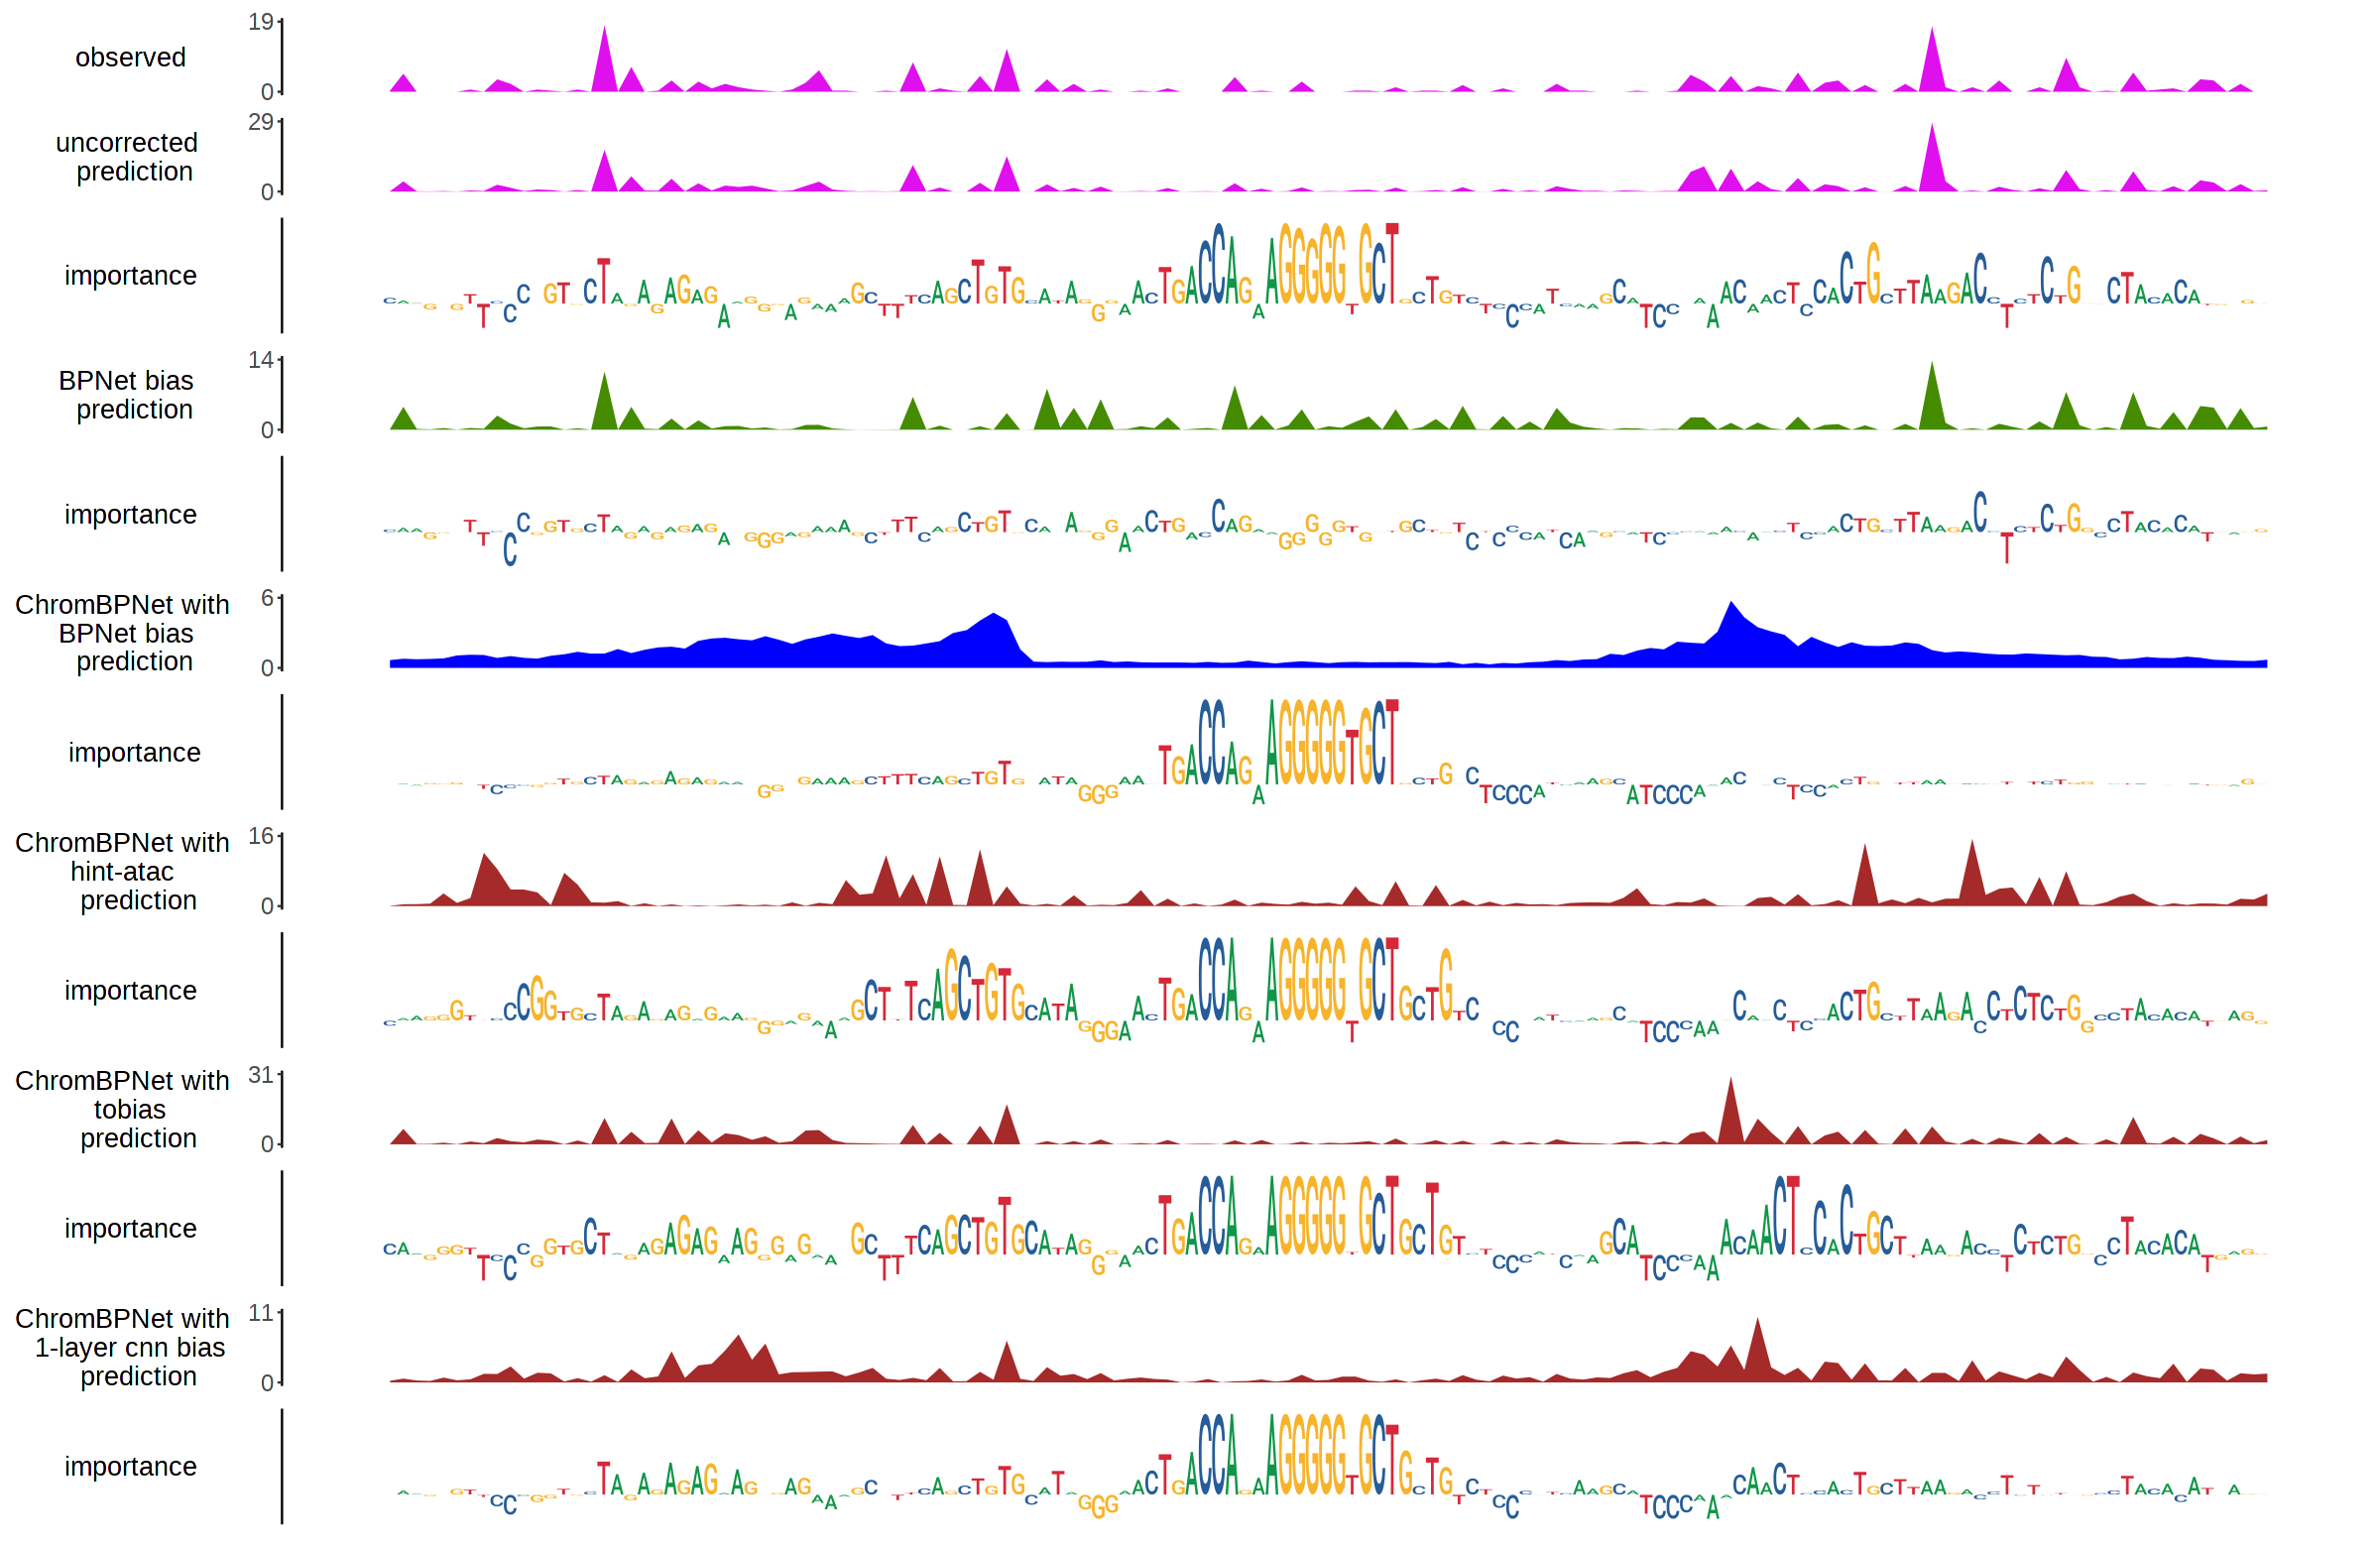

In [293]:
REGION = GRanges(range)

options(repr.plot.width = 20, repr.plot.height = nrow(config))

p = generate_plots(config, REGION, genome)

p
#ggsave(paste("subfigs/locus_plots/",file_name,sep=""), p, height=nrow(config), width=20, useDingbats=F)


In [ ]:
#wrap_plots(ggplot() + theme_void() + annotate("segment", x=0, xend=0, y=0, yend=0.25),p,heights=c(10,10),widths=c(1,20),ncol=2)


In [167]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.6 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/libf77blas.so.3.10.3
LAPACK: /usr/lib/x86_64-linux-gnu/atlas/liblapack.so.3.10.3

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=C             
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] BSgenome.Hsapiens.UCSC.hg38_1.4.3 BSgenome_1.58.0                  
 [3] Biostrings_2.58.0                 XVector_0.30.0                   
 [5] dplyr_1.0.9                       magrittr_2.0.3                   
 [7] readr_2.1.2          